In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import joblib
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format','{:.3f}'.format)
pd.set_option('display.max_columns',None)

In [3]:
churn_df = pd.read_csv('churn_cleaned1.csv')

In [4]:
churn_df.head()

gender  age  no_of_days_subscribed  multi_screen  mail_subscribed  \
0       0   36                     62             0                0   
1       0   39                    149             0                0   
2       0   65                    126             0                0   
3       0   24                    131             0                1   
4       0   40                    191             0                0   

   weekly_mins_watched  minimum_daily_mins  weekly_max_night_mins  \
0              148.350              12.200                     82   
1              294.450               7.700                     87   
2               87.300              11.900                     91   
3              321.300               9.500                    102   
4              243.000              10.900                     83   

   videos_watched  customer_support_calls  churn  
0               1                       1      0  
1               3                       2      0  
2               1                       5      1  
3               4                       3      0  
4               7                       1      0

- Train Test Split

In [5]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

In [6]:
X.shape, y.shape

((2000, 10), (2000,))

- Check Class Imbalance problem is there or not

In [7]:
#churn_df['churn'].value_counts()
y.value_counts()

0    1738
1     262
Name: churn, dtype: int64

In [8]:
#churn_df['churn'].value_counts(normalize=True)
y.value_counts(normalize=True)

0   0.869
1   0.131
Name: churn, dtype: float64

In [9]:
1738/262

# This value is greater than 2 & no of records of minority class is less than 500
# So, we will apply SMOTE technique

6.633587786259542

In [10]:
# sampling_strategy = {
#     3: 50,  # Increase class 3 to 50 samples
#     8: 50,  # Increase class 8 to 50 samples
#     4: 55   # Increase class 4 to 55 samples
# }

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Apply the AMOTE object on training data
X_new, y_new = smote.fit_resample(X=X,y=y)

In [11]:
X_new.shape, y_new.shape

((3476, 10), (3476,))

In [12]:
y_new.value_counts()

0    1738
1    1738
Name: churn, dtype: int64

In [13]:
rf = RandomForestClassifier()

In [14]:
rf

RandomForestClassifier()

In [15]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [16]:
params = {'class_weight': ['balanced',None],   # 2
 'criterion': ['gini','entropy'],              # 2
 'max_depth': [7,8,9],                         # 3
 'max_features': ['sqrt','log2'],              # 2
 'min_samples_leaf': [1,3],                    # 2
 'min_samples_split': [2,4],                   # 2
 'n_estimators': [100,150],                    # 2
 'random_state': [42,51]                       # 2
}

# 2*2*2*2*2*2*2*3 = 384

In [17]:
grid_search = GridSearchCV(rf,param_grid=params,scoring='accuracy',cv=5,verbose=True)

# cv = 5 means  384*5 = 1920

In [18]:
grid_search

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150], 'random_state': [42, 51]},
             scoring='accuracy', verbose=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=0.25,random_state=43)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150], 'random_state': [42, 51]},
             scoring='accuracy', verbose=True)

In [20]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=42)

In [21]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [22]:
grid_search.best_score_

0.835827799471985

In [23]:
grid_search.cv_results_

{'mean_fit_time': array([0.56445432, 0.55287957, 0.80588627, 0.84492784, 0.59576921,
        0.58010645, 0.84737563, 0.79744716, 0.55764599, 0.57898564,
        0.89505401, 0.85004826, 0.61996479, 0.53595304, 0.80156493,
        0.82969875, 0.56300955, 0.57982116, 0.85376201, 0.8115715 ,
        0.54075799, 0.5520196 , 0.89594002, 0.82456398, 0.55225625,
        0.57317395, 0.95998721, 1.22426209, 0.67229481, 0.664992  ,
        0.97465906, 0.94216347, 0.73808436, 0.76218443, 1.09838719,
        1.10094829, 0.72002244, 0.6946825 , 1.03578048, 0.97059603,
        0.66309042, 0.5950367 , 0.92098231, 0.87996478, 0.61941457,
        0.62419548, 0.89745674, 0.87610278, 0.60670609, 0.61446762,
        0.88676014, 0.88351765, 0.58824806, 0.58932037, 0.86937242,
        0.86149015, 0.55272279, 0.56639147, 0.83965335, 0.85491834,
        0.5798564 , 0.56536689, 0.89080706, 0.84609079, 0.62088265,
        0.62540312, 0.97882352, 0.8973774 , 0.5900238 , 0.59412198,
        0.94169798, 0.90128946,

In [24]:
grid_search.feature_names_in_

array(['gender', 'age', 'no_of_days_subscribed', 'multi_screen',
       'mail_subscribed', 'weekly_mins_watched', 'minimum_daily_mins',
       'weekly_max_night_mins', 'videos_watched',
       'customer_support_calls'], dtype=object)

In [25]:
grid_search.score(X_train,y_train)

0.9102416570771001

In [26]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_class_weight', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'param_random_state', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [27]:
len(grid_search.cv_results_['split0_test_score'])

384

In [28]:
c1 = grid_search.cv_results_['split0_test_score']
c2 = grid_search.cv_results_['split1_test_score']
c3 = grid_search.cv_results_['split2_test_score']
c4 = grid_search.cv_results_['split3_test_score']
c5 = grid_search.cv_results_['split4_test_score']

cv_df = pd.DataFrame(data = zip(c1,c2,c3,c4,c5),
                     index = grid_search.cv_results_['params'],
                     columns=['C1','C2','C3','C4','C5'])

cv_df

C1    C2    C3    C4  \
{'class_weight': 'balanced', 'criterion': 'gini... 0.816 0.805 0.808 0.810   
{'class_weight': 'balanced', 'criterion': 'gini... 0.824 0.807 0.814 0.821   
{'class_weight': 'balanced', 'criterion': 'gini... 0.828 0.807 0.816 0.804   
{'class_weight': 'balanced', 'criterion': 'gini... 0.826 0.805 0.812 0.812   
{'class_weight': 'balanced', 'criterion': 'gini... 0.818 0.808 0.808 0.810   
...                                                  ...   ...   ...   ...   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.810 0.812 0.820   
{'class_weight': None, 'criterion': 'entropy', ... 0.830 0.822 0.814 0.823   
{'class_weight': None, 'criterion': 'entropy', ... 0.831 0.816 0.816 0.823   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.820 0.814 0.816   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.810 0.812 0.820   

                                                      C5  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820  
{'class_weight': 'balanced', 'criterion': 'gini... 0.812  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820  
{'class_weight': 'balanced', 'criterion': 'gini... 0.810  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820  
...                                                  ...  
{'class_weight': None, 'criterion': 'entropy', ... 0.814  
{'class_weight': None, 'criterion': 'entropy', ... 0.818  
{'class_weight': None, 'criterion': 'entropy', ... 0.810  
{'class_weight': None, 'criterion': 'entropy', ... 0.812  
{'class_weight': None, 'criterion': 'entropy', ... 0.814  

[384 rows x 5 columns]

In [29]:
avg = [i.sum()/5 for i in cv_df.values]
cv_df['Average'] = avg
cv_df

C1    C2    C3    C4  \
{'class_weight': 'balanced', 'criterion': 'gini... 0.816 0.805 0.808 0.810   
{'class_weight': 'balanced', 'criterion': 'gini... 0.824 0.807 0.814 0.821   
{'class_weight': 'balanced', 'criterion': 'gini... 0.828 0.807 0.816 0.804   
{'class_weight': 'balanced', 'criterion': 'gini... 0.826 0.805 0.812 0.812   
{'class_weight': 'balanced', 'criterion': 'gini... 0.818 0.808 0.808 0.810   
...                                                  ...   ...   ...   ...   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.810 0.812 0.820   
{'class_weight': None, 'criterion': 'entropy', ... 0.830 0.822 0.814 0.823   
{'class_weight': None, 'criterion': 'entropy', ... 0.831 0.816 0.816 0.823   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.820 0.814 0.816   
{'class_weight': None, 'criterion': 'entropy', ... 0.835 0.810 0.812 0.820   

                                                      C5  Average  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820    0.812  
{'class_weight': 'balanced', 'criterion': 'gini... 0.812    0.815  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820    0.815  
{'class_weight': 'balanced', 'criterion': 'gini... 0.810    0.813  
{'class_weight': 'balanced', 'criterion': 'gini... 0.820    0.813  
...                                                  ...      ...  
{'class_weight': None, 'criterion': 'entropy', ... 0.814    0.818  
{'class_weight': None, 'criterion': 'entropy', ... 0.818    0.821  
{'class_weight': None, 'criterion': 'entropy', ... 0.810    0.819  
{'class_weight': None, 'criterion': 'entropy', ... 0.812    0.819  
{'class_weight': None, 'criterion': 'entropy', ... 0.814    0.818  

[384 rows x 6 columns]

In [30]:
cv_df['Average'].max(), grid_search.best_score_

(0.835827799471985, 0.835827799471985)

In [31]:
cv_df['Average'].idxmax()

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [32]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

- Apply Cross Validation now as we know the best estimator & params now

In [33]:
accuracy_list=cross_val_score(grid_search.best_estimator_,
                              X_train,
                              y_train,
                              cv=5,
                              scoring='accuracy')
accuracy_list

# It will give each part accuracy
# by using best model (best estimator)

array([0.84291188, 0.8256705 , 0.82725528, 0.83685221, 0.84644914])

In [34]:
np.mean(accuracy_list), grid_search.best_score_

(0.835827799471985, 0.835827799471985)

- Model Evaluation

In [35]:
best_model = grid_search.best_estimator_

In [36]:
ypred_train = best_model.predict(X_train)

In [37]:
ypred_test = best_model.predict(X_test)

In [38]:
train_acc = accuracy_score(y_train,ypred_train)
train_acc

0.9102416570771001

In [39]:
test_acc = accuracy_score(y_test,ypred_test)
test_acc

0.8527042577675489

- that means our model is not overfit

In [40]:
print(classification_report(y_test,ypred_test))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       429
           1       0.89      0.81      0.85       440

    accuracy                           0.85       869
   macro avg       0.86      0.85      0.85       869
weighted avg       0.86      0.85      0.85       869



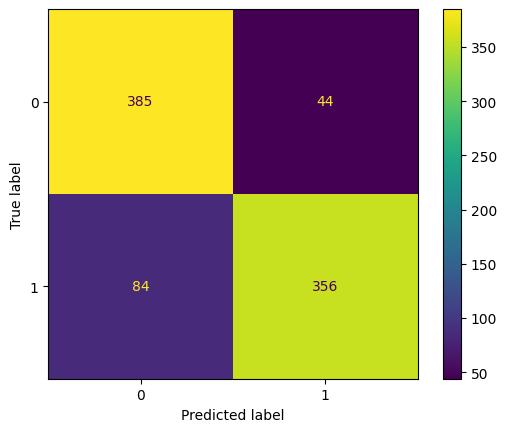

In [41]:
cmt = confusion_matrix(y_test,ypred_test)
disp = ConfusionMatrixDisplay(cmt,display_labels=best_model.classes_)
disp.plot()
plt.show()

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test,ypred_test).ravel()
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

True Negative: 385
False Positive: 44
False Negative: 84
True Positive: 356


In [43]:
ypred_test_prob = best_model.predict_proba(X_test)
ypred_test_prob

array([[0.74641008, 0.25358992],
       [0.70709239, 0.29290761],
       [0.77628863, 0.22371137],
       ...,
       [0.11454997, 0.88545003],
       [0.50402999, 0.49597001],
       [0.91343285, 0.08656715]])

In [44]:
ypred_test_prob[:,1]  # Class 1 probabilities

array([0.25358992, 0.29290761, 0.22371137, 0.28241939, 0.58568731,
       0.08958682, 0.96329085, 0.26437514, 0.59729074, 0.97644518,
       0.36406399, 0.4703202 , 0.90919269, 0.22619224, 0.83685764,
       0.38883721, 0.64138879, 0.13250456, 0.6240747 , 0.2488001 ,
       0.79725883, 0.94571661, 0.28555883, 0.76300174, 0.2060796 ,
       0.049647  , 0.56095354, 0.23105192, 0.40632114, 0.61260058,
       0.9431437 , 0.52150846, 0.08422902, 0.55851457, 0.58096821,
       0.92314079, 0.3309016 , 0.40439776, 0.56263326, 0.46074588,
       0.94886911, 0.14883218, 0.73354828, 0.05184037, 0.36857806,
       0.35642095, 0.78829322, 0.94847473, 0.19527867, 0.10247924,
       0.61538906, 0.7745278 , 0.43666969, 0.77581071, 0.63452022,
       0.72658082, 0.59922435, 0.44006595, 0.36191341, 0.93795482,
       0.71666994, 0.67567096, 0.26671959, 0.28202357, 0.11286287,
       0.16206108, 0.54588036, 0.58157502, 0.90559176, 0.63162611,
       0.4811318 , 0.94946589, 0.93504489, 0.21934664, 0.03485

In [45]:
fpr, tpr, thresholds = roc_curve(y_test,ypred_test_prob[:,1])

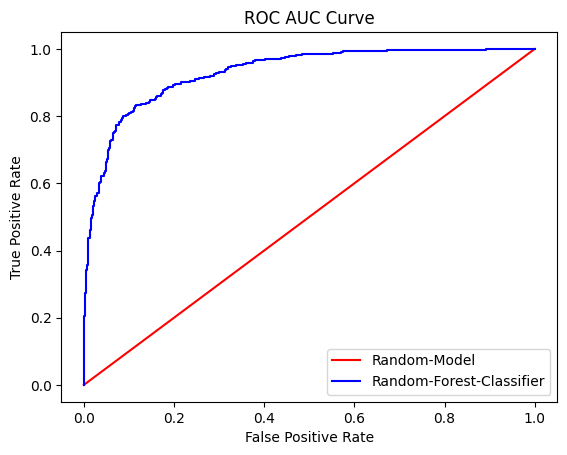

Area under the curve: 0.930011655011655


In [46]:
plt.plot([0,1],[0,1],color='red',label='Random-Model')
plt.plot(fpr,tpr,color='blue',label='Random-Forest-Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()
print(f"Area under the curve: {auc(fpr,tpr)}")


- Feature Importance

In [47]:
best_model.feature_importances_

array([0.05596934, 0.05775922, 0.07745558, 0.03374266, 0.0984774 ,
       0.30416231, 0.09698767, 0.06160175, 0.05897655, 0.15486752])

In [48]:
feature_importance = pd.DataFrame()

In [49]:
feature_importance['Features'] = X_train.columns

In [50]:
feature_importance['Importance'] = best_model.feature_importances_

In [51]:
feature_importance.sort_values(by='Importance',ascending=False)

Features  Importance
5     weekly_mins_watched       0.304
9  customer_support_calls       0.155
4         mail_subscribed       0.098
6      minimum_daily_mins       0.097
2   no_of_days_subscribed       0.077
7   weekly_max_night_mins       0.062
8          videos_watched       0.059
1                     age       0.058
0                  gender       0.056
3            multi_screen       0.034

- Save the model

In [52]:
joblib.dump(best_model,'RF_Classifier.joblib')

['RF_Classifier.joblib']